<a href="https://colab.research.google.com/github/aarohityagi/car-price-predictor/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install yfinance pandas numpy statsmodels scikit-learn seaborn

In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", "NVDA", "JPM", "V", "PG", "UNH"]
start_date = "2020-01-01"
end_date = "2023-12-31"

In [18]:
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  10 of 10 completed


In [19]:
data = data.stack(level=1)
data.index.names = ['Date', 'Ticker']
data = data.reset_index()
data = data.pivot(index='Date', columns='Ticker')
data = data.dropna(axis=0, how='all')

<ipython-input-19-c6f3a379a1b1>:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=1)


displaying clean data

In [20]:
print(data.head())

Price           Close                                                          \
Ticker           AAPL       AMZN       GOOG         JPM        MSFT      NVDA   
Date                                                                            
2020-01-02  72.716072  94.900497  68.046196  121.477226  153.323288  5.972161   
2020-01-03  72.009117  93.748497  67.712280  119.874176  151.414108  5.876572   
2020-01-06  72.582909  95.143997  69.381874  119.778809  151.805481  5.901216   
2020-01-07  72.241539  95.343002  69.338585  117.742546  150.421356  5.972660   
2020-01-08  73.403633  94.598503  69.884995  118.661049  152.817322  5.983862   

Price                                                      ...     Volume  \
Ticker              PG       TSLA         UNH           V  ...       AAPL   
Date                                                       ...              
2020-01-02  108.419891  28.684000  270.618561  184.177444  ...  135480400   
2020-01-03  107.690704  29.534000  267.8800

PEFORMING EDA ON DATA SET

In [21]:
def perform_eda(stock_data, ticker):
    ticker_data = stock_data.loc[:, (slice(None), ticker)]
    ticker_data.columns = ticker_data.columns.droplevel(1)
    plt.figure(figsize=(15, 7))
    plt.plot(ticker_data['Close'], label=f'{ticker} Close Price')
    plt.title(f'{ticker} Close Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 7))
    plt.plot(ticker_data['Volume'], label=f'{ticker} Volume')
    plt.title(f'{ticker} Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 7))
    sns.heatmap(ticker_data.corr(), annot=True, cmap='coolwarm')
    plt.title(f'{ticker} Correlation Heatmap')
    plt.show()

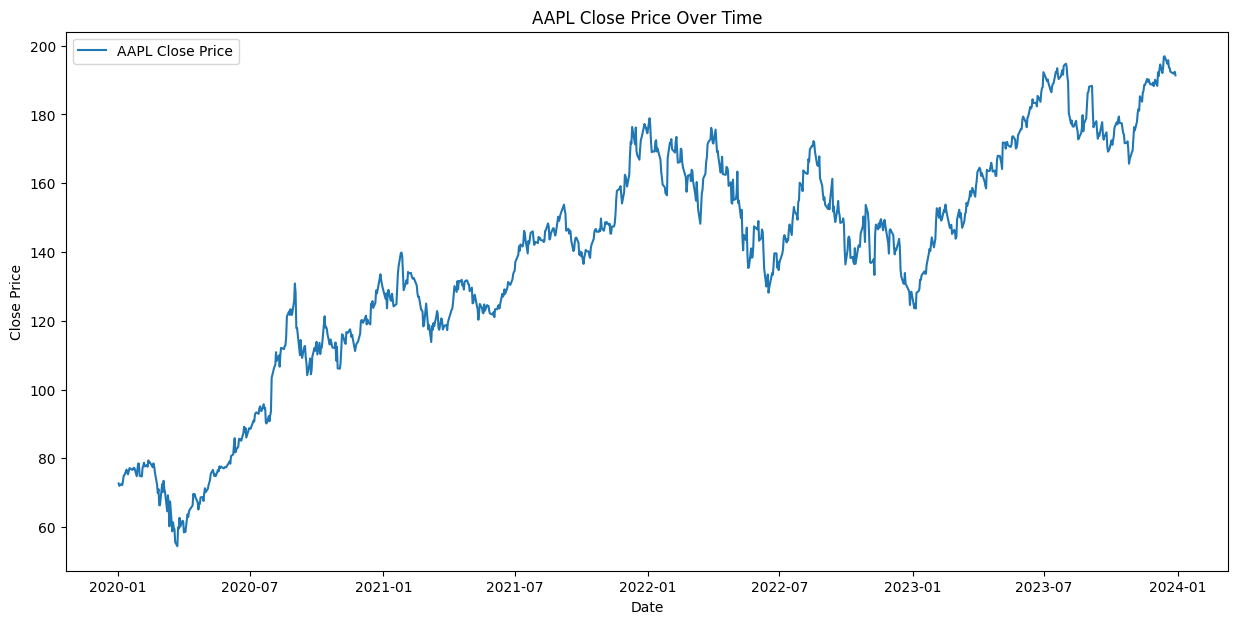

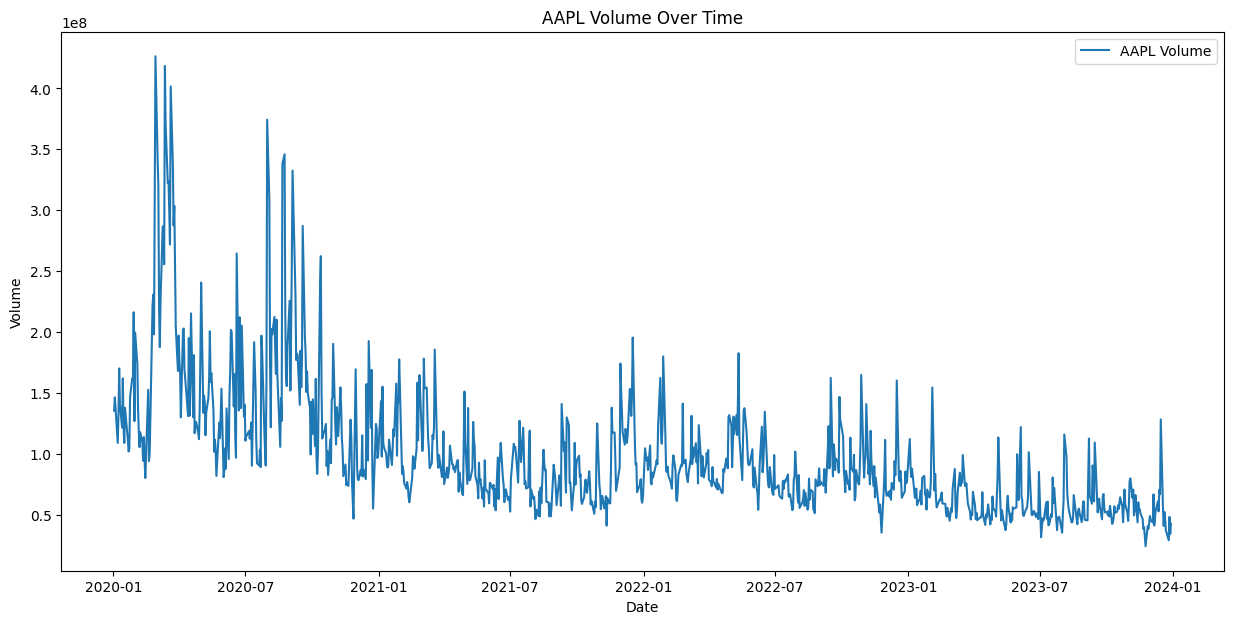

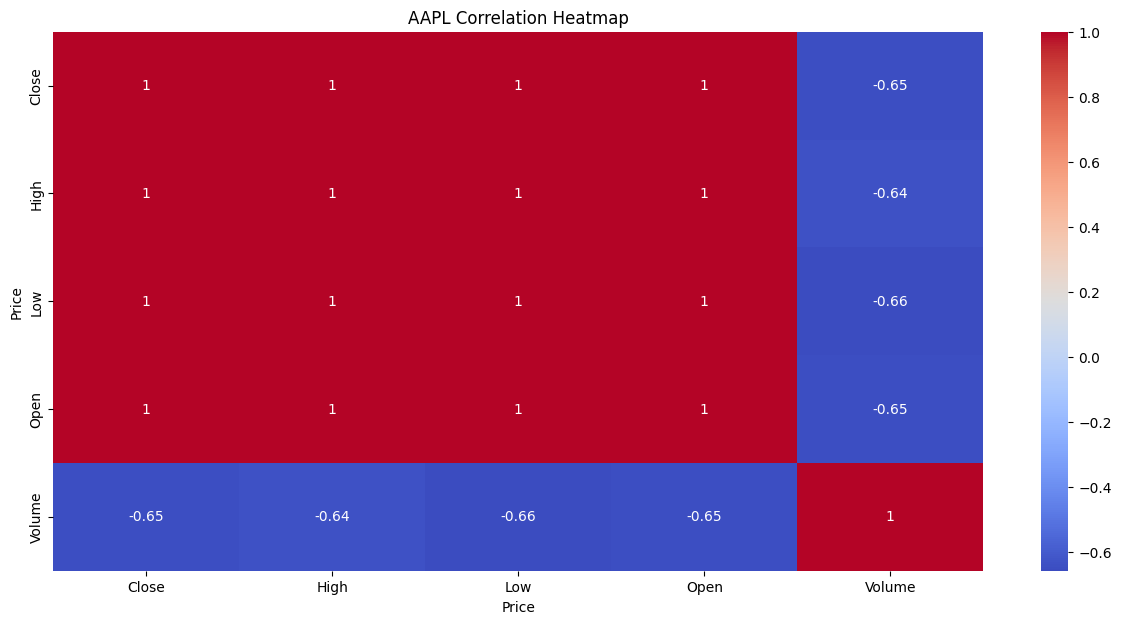

In [22]:
perform_eda(data, "AAPL")

In [23]:
def feature_engineering(stock_data, ticker):
    ticker_data = stock_data.loc[:, (slice(None), ticker)]
    ticker_data.columns = ticker_data.columns.droplevel(1)
    ticker_data['Return'] = ticker_data['Close'].pct_change()
    for i in range(1, 6):
        ticker_data[f'Lag_{i}'] = ticker_data['Return'].shift(i)
    for i in [5, 20, 50]:
        ticker_data[f'MA_{i}'] = ticker_data['Close'].rolling(window=i).mean()
    ticker_data['Volume_Change'] = ticker_data['Volume'].pct_change()
    ticker_data.dropna(inplace=True)
    return ticker_data


FIXING WARNING ISSUES

In [25]:
def feature_engineering(stock_data, ticker):
    ticker_data = stock_data.loc[:, (slice(None), ticker)].copy()
    ticker_data.columns = ticker_data.columns.droplevel(1)

    # Calculate daily returns
    ticker_data.loc[:, 'Return'] = ticker_data['Close'].pct_change()

    # Add past returns
    for i in range(1, 6):
        ticker_data.loc[:, f'Lag_{i}'] = ticker_data['Return'].shift(i)

    # Calculate moving averages
    for i in [5, 20, 50]:
        ticker_data.loc[:, f'MA_{i}'] = ticker_data['Close'].rolling(window=i).mean() # Use .loc

    # Calculate volume changes
    ticker_data.loc[:, 'Volume_Change'] = ticker_data['Volume'].pct_change() # Use .loc

    # Remove any rows with missing data
    ticker_data.dropna(inplace=True)

    return ticker_data

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from itertools import product
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

ARIMA MODEL MAKING

In [34]:
def arima_model(stock_data, ticker):
    ticker_data = stock_data[('Close', ticker)].copy()
    ticker_data.index = pd.to_datetime(ticker_data.index)
    ticker_data = ticker_data.asfreq('D')
    ticker_data = ticker_data.fillna(method='ffill')

    train_size = int(len(ticker_data) * 0.8)
    train, test = ticker_data[:train_size], ticker_data[train_size:]

    p = d = q = range(0, 3)
    pdq = list(product(p, d, q))
    best_aic = float("inf")
    best_pdq = None

    for param in pdq:
        try:
            model = ARIMA(train, order=param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
        except:
            continue

    model = ARIMA(train, order=best_pdq)
    results = model.fit()
    forecast = results.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    return forecast, rmse, mae, mape


In [35]:
arima_forecast, arima_rmse, arima_mae, arima_mape = arima_model(data, "AAPL")
print(f"ARIMA RMSE: {arima_rmse}, MAE: {arima_mae}, MAPE: {arima_mape}")

ARIMA RMSE: 32.78664652218116, MAE: 30.87115868101387, MAPE: 0.17027582066593738


In [39]:
def evaluate_models(arima_rmse, arima_mae, arima_mape, gb_rmse, gb_mae, gb_mape):
    """Evaluates and compares the models."""
    print("ARIMA Model Evaluation:")
    print(f"RMSE: {arima_rmse}, MAE: {arima_mae}, MAPE: {arima_mape}")
    print("\nGradient Boosting Model Evaluation:")
    print(f"RMSE: {gb_rmse}, MAE: {gb_mae}, MAPE: {gb_mape}")

In [40]:
evaluate_models(arima_rmse, arima_mae, arima_mape, gb_rmse, gb_mae, gb_mape)

ARIMA Model Evaluation:
RMSE: 32.78664652218116, MAE: 30.87115868101387, MAPE: 0.17027582066593738

Gradient Boosting Model Evaluation:
RMSE: 8.651423929069834, MAE: 5.8360689029804425, MAPE: 0.030939879195185312


defining gradient

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

In [37]:
def gradient_boosting_model(stock_data, ticker):
    """Develops and evaluates a Gradient Boosting model."""
    features = feature_engineering(stock_data, ticker)
    y = features['Close']
    X = features.drop('Close', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    return predictions, rmse, mae, mape

In [38]:
gb_predictions, gb_rmse, gb_mae, gb_mape = gradient_boosting_model(data, "AAPL")
print(f"Gradient Boosting RMSE: {gb_rmse}, MAE: {gb_mae}, MAPE: {gb_mape}")

Gradient Boosting RMSE: 8.651423929069834, MAE: 5.8360689029804425, MAPE: 0.030939879195185312


In [47]:
import matplotlib.pyplot as plt
import pandas as pd

VISUALIZING ARIMA FORECASTS

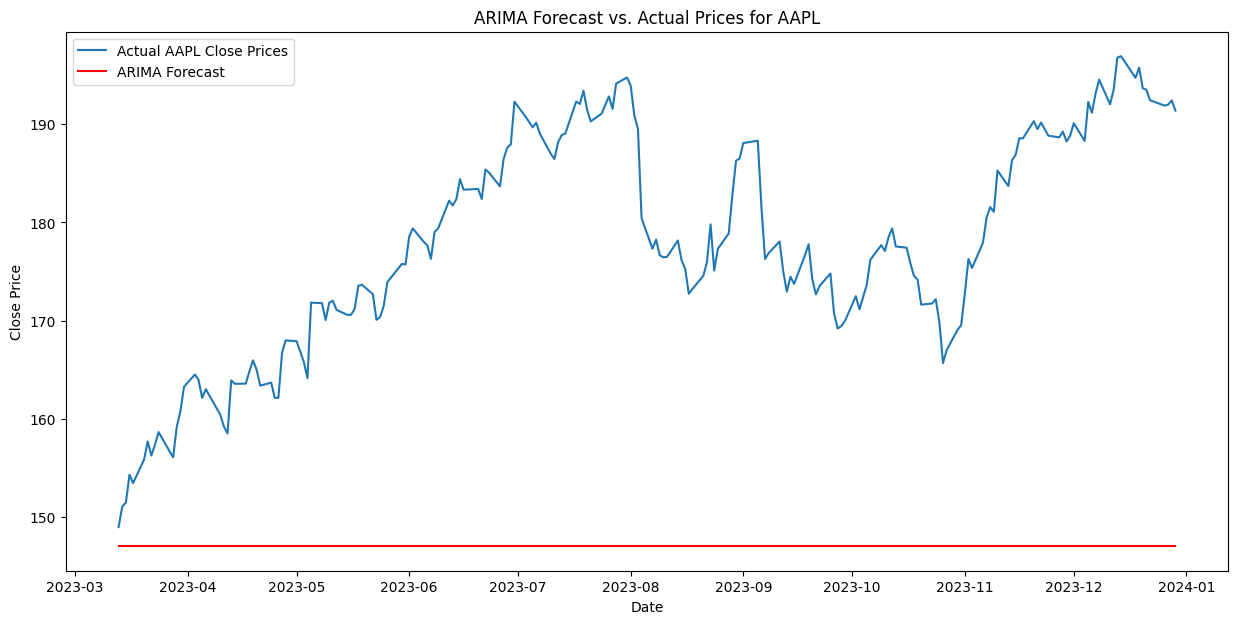

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
def visualize_arima_forecast(test, forecast, ticker):
    """Visualizes the ARIMA forecast against the actual prices."""
    plt.figure(figsize=(15, 7))
    plt.plot(test.index, test, label=f'Actual {ticker} Close Prices')
    plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
    plt.title(f'ARIMA Forecast vs. Actual Prices for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

trading_days = data[('Close', "AAPL")].index
valid_forecast_index = arima_forecast.index.intersection(trading_days)
test_data = data[('Close', "AAPL")].loc[valid_forecast_index]
forecast_filtered = arima_forecast.loc[valid_forecast_index]

visualize_arima_forecast(test_data, forecast_filtered, "AAPL")

VISUALIZING GRADIENT BOOSTING PREDICTIONS

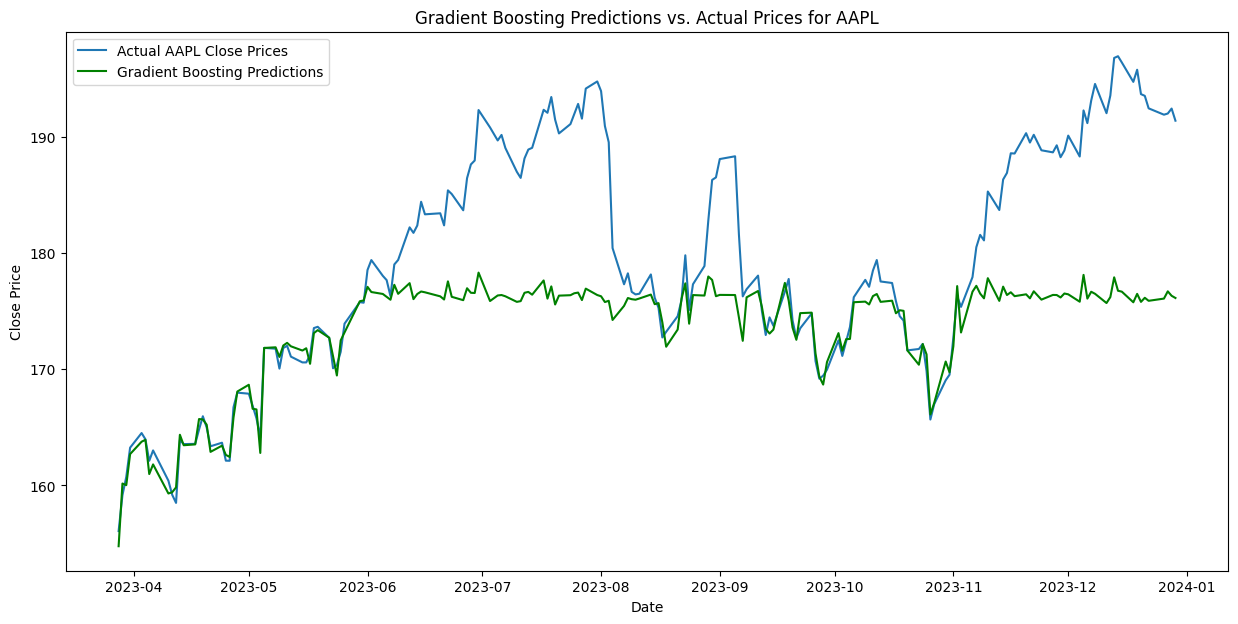

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
def visualize_gb_predictions(y_test, predictions, ticker):
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label=f'Actual {ticker} Close Prices')
    plt.plot(y_test.index, predictions, label='Gradient Boosting Predictions', color='green')
    plt.title(f'Gradient Boosting Predictions vs. Actual Prices for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()
features = feature_engineering(data, "AAPL")
y = features['Close']
X = features.drop('Close', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
visualize_gb_predictions(y_test, gb_predictions, "AAPL")